<a href="https://colab.research.google.com/github/w000yiran/Deep-Branching-for-BSB/blob/main/comparison_w_2703_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports & basic configuration

In [18]:
try:
    # always cd to the right directory in google colab
    from google.colab import drive
    drive.mount('/content/drive')
    %cd "/content/drive/MyDrive/Colab Notebooks/deep_branching"
except:
    pass

import math
from scipy import special
import numpy as np
import torch
import matplotlib.pyplot as plt
import time
import scipy
from branch import Net
from galerkin import DGMNet
from bsde import BSDENet
import logging
import constant as cst

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Colab Notebooks/deep_branching


In [19]:
# perfect reproducibility is not guaranteed with different version of torch

import torchaudio
import torchvision

print(f"torch version: {torch.__version__}")
print(f"torchaudio version: {torchaudio.__version__}")
print(f"torchvision version: {torchvision.__version__}")

torch version: 1.13.1+cu116
torchaudio version: 0.13.1+cu116
torchvision version: 0.14.1+cu116


In [20]:
print("Information of the allocated GPU.")
!nvidia-smi

Information of the allocated GPU.
Mon Mar 27 05:04:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    31W /  70W |    877MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                      

In [21]:
# performance evaluation for PDE
def compare_performance(
    grid_1d,
    grid_nd,
    grid_with_t,
    t_lo,
    true,
    terminal,
    fname=None,
    debug_mode=False,
    disable_galerkin=False,
    disable_bsde=False,
    disable_branch=False,
    seeds=list(range(10)),
    **kwargs,
):

    x_lo, x_hi = grid_nd.min(), grid_nd.max()
    grid_nd = grid_nd.astype(np.float32)
    grid_with_t = grid_with_t.astype(np.float32)

    fname = f"{fname}_dim_{grid_nd.shape[0]}" if fname is not None else None
    counter = 1

    branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error, branch = (
        [],
        [],
        [],
        [],
        0,
    )
    branch_fdb_runtime, branch_total_runtime = [], []
    dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error, dgm = [], [], [], [], 0
    bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error, bsde = [], [], [], [], 0
    for seed in seeds:
        ######### Deep branching method
        if not disable_branch:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep branching method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = Net(t_lo=t_lo, t_hi=t_lo, x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            branch_total_runtime.append(time.time() - start)
            branch_fdb_runtime.append(model.fdb_runtime)
            branch_runtime.append(branch_total_runtime[-1] - branch_fdb_runtime[-1])
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            branch += tmp
            branch_l1_error.append((np.abs(tmp - true)).mean())
            branch_l2_error.append(((tmp - true) ** 2).mean())
            branch_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {branch_runtime[-1]:.0f} seconds; L1 error: {branch_l1_error[-1]:.2E}; L2 error: {branch_l2_error[-1]:.2E}; rel error: {branch_rel_error[-1]:.2E}."
            )
            print(
                f"fdb runtime: {branch_fdb_runtime[-1]:.0f} seconds; total runtime: {branch_total_runtime[-1]:.0f} seconds."
            )

        ######### Deep galerkin method
        if not disable_galerkin:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep galerkin method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = DGMNet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            dgm_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_with_t.T, device=device)).detach().cpu().numpy()
            )
            dgm += tmp
            dgm_l1_error.append((np.abs(tmp - true)).mean())
            dgm_l2_error.append(((tmp - true) ** 2).mean())
            dgm_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {dgm_runtime[-1]:.0f} seconds; L1 error: {dgm_l1_error[-1]:.2E}; L2 error: {dgm_l2_error[-1]:.2E}; rel error: {dgm_rel_error[-1]:.2E}."
            )

        ######### Deep BSDE method
        if not disable_bsde:
            torch.manual_seed(seed)
            print(
                f"#### Starting deep BSDE method with seed {seed} - {counter} out of {len(seeds)} times"
            )
            start = time.time()
            model = BSDENet(t_lo=t_lo, t_hi=kwargs["T"], x_lo=x_lo, x_hi=x_hi, **kwargs)
            model.train_and_eval(debug_mode)
            bsde_runtime.append(time.time() - start)
            tmp = (
                model(torch.tensor(grid_nd.T, device=device))
                .squeeze(-1)
                .detach()
                .cpu()
                .numpy()
            )
            bsde += tmp
            bsde_l1_error.append((np.abs(tmp - true)).mean())
            bsde_l2_error.append(((tmp - true) ** 2).mean())
            bsde_rel_error.append((np.abs(tmp - true) / np.abs(true)).mean())
            print(
                f"Time taken: {bsde_runtime[-1]:.0f} seconds; L1 error: {bsde_l1_error[-1]:.2E}; L2 error: {bsde_l2_error[-1]:.2E}; rel error: {bsde_rel_error[-1]:.2E}."
            )

        print("\n")
        counter += 1

    # Plot
    f = plt.figure()
    plt.plot(grid_1d, true, label="True solution")
    plt.plot(grid_1d, terminal, label="Terminal condition")
    # save into csv
    if fname is not None:
        plt_data = np.stack((grid_1d, true, terminal), axis=-1)
        plt_header = "x, true, terminal"

    if not disable_branch:
        branch /= len(seeds)
        branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error = (
            np.array(branch_runtime),
            np.array(branch_l1_error),
            np.array(branch_l2_error),
            np.array(branch_rel_error),
        )
        branch_fdb_runtime, branch_total_runtime = np.array(
            branch_fdb_runtime
        ), np.array(branch_total_runtime)
        print("\n")
        print("######## Summary for deep branching method")
        print(f"runtime:        {branch_runtime.mean():.0f}")
        print(f"fdb runtime:    {branch_fdb_runtime.mean():.0f}")
        print(f"total runtime:  {branch_total_runtime.mean():.0f}")
        print(f"mean L1 error:  {branch_l1_error.mean():.2E}")
        print(f"std L1 error:   {branch_l1_error.std():.2E}")
        print(f"mean L2 error:  {branch_l2_error.mean():.2E}")
        print(f"std L2 error:   {branch_l2_error.std():.2E}")
        print(f"mean rel error: {branch_rel_error.mean():.2E}")
        print(f"std rel error:  {branch_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, branch, label="Deep branching")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(branch, axis=-1)), axis=-1
            )
            plt_header += ", branch"
            data = np.stack(
                (branch_runtime, branch_l1_error, branch_l2_error, branch_rel_error),
                axis=-1,
            )
            np.savetxt(
                "log/branch_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    if not disable_galerkin:
        dgm /= len(seeds)
        dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error = (
            np.array(dgm_runtime),
            np.array(dgm_l1_error),
            np.array(dgm_l2_error),
            np.array(dgm_rel_error),
        )
        print("\n")
        print("######## Summary for deep galerkin method")
        print(f"runtime:        {dgm_runtime.mean():.0f}")
        print(f"mean L1 error:  {dgm_l1_error.mean():.2E}")
        print(f"std L1 error:   {dgm_l1_error.std():.2E}")
        print(f"mean L2 error:  {dgm_l2_error.mean():.2E}")
        print(f"std L2 error:   {dgm_l2_error.std():.2E}")
        print(f"mean rel error: {dgm_rel_error.mean():.2E}")
        print(f"std rel error:  {dgm_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, dgm, label="Deep Galerkin")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate((plt_data, np.expand_dims(dgm, axis=-1)), axis=-1)
            plt_header += ", dgm"
            data = np.stack(
                (dgm_runtime, dgm_l1_error, dgm_l2_error, dgm_rel_error), axis=-1
            )
            np.savetxt(
                "log/dgm_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    ######### Deep BSDE method
    if not disable_bsde:
        bsde /= len(seeds)
        bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error = (
            np.array(bsde_runtime),
            np.array(bsde_l1_error),
            np.array(bsde_l2_error),
            np.array(bsde_rel_error),
        )
        print("\n")
        print("######## Summary for deep BSDE method")
        print(f"runtime:        {bsde_runtime.mean():.0f}")
        print(f"mean L1 error:  {bsde_l1_error.mean():.2E}")
        print(f"std L1 error:   {bsde_l1_error.std():.2E}")
        print(f"mean L2 error:  {bsde_l2_error.mean():.2E}")
        print(f"std L2 error:   {bsde_l2_error.std():.2E}")
        print(f"mean rel error: {bsde_rel_error.mean():.2E}")
        print(f"std rel error:  {bsde_rel_error.std():.2E}")
        # Plot
        plt.plot(grid_1d, bsde, label="Deep BSDE")
        # save into csv
        if fname is not None:
            plt_data = np.concatenate(
                (plt_data, np.expand_dims(bsde, axis=-1)), axis=-1
            )
            plt_header += ", bsde"
            data = np.stack(
                (bsde_runtime, bsde_l1_error, bsde_l2_error, bsde_rel_error), axis=-1
            )
            np.savetxt(
                "log/bsde_" + fname + ".csv",
                data,
                delimiter=",",
                header="runtime,l1_error,l2_error,rel_error",
                comments="",
            )

    plt.legend()
    plt.show()
    f.savefig(f"plot/{'comparison' if fname is None else fname}.pdf")
    if fname is not None:
        np.savetxt(
            "log/plt_" + fname + ".csv", plt_data, delimiter=",", header=plt_header, comments=""
        )

# Black-Scholes converted PDE


## Simplified Payoff
$\phi(y)= e^{\sigma y} - K$

In [22]:
# function definition
deriv_map = np.array([0,1]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    v = -cst.r*y[0]+(cst.r-cst.sigma*cst.sigma/2)/cst.sigma*y[1]
    return v

dgm_deriv_map = np.array([0,1,2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    v = .5*y[2]-cst.r*y[0]+(cst.r-cst.sigma*cst.sigma/2)/cst.sigma*y[1]
    return v

def phi_example(x):
    return torch.exp(cst.sigma*x[0])-cst.K 

def exact_example(t, x, T):
    v = np.exp(cst.sigma*x[0]) - cst.K*np.exp(-cst.r*t)
    return v

t_lo, x_lo, x_hi, n = 0., -4., 4., 0
grid = np.linspace(x_lo, x_hi, 100) 
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 146 seconds; L1 error: 2.44E-02; L2 error: 5.97E-04; rel error: 9.11E-02.
fdb runtime: 0 seconds; total runtime: 146 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 52 seconds; L1 error: 2.18E-02; L2 error: 4.99E-04; rel error: 8.32E-02.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 84 seconds; L1 error: 2.28E-02; L2 error: 5.25E-04; rel error: 8.35E-02.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 144 seconds; L1 error: 2.46E-02; L2 error: 6.06E-04; rel error: 9.22E-02.
fdb runtime: 0 seconds; total runtime: 144 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 51 seconds; L1 error: 2.44E-02; L2 error: 6.16E-04; rel error: 9.35E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 85 seconds; L1 error: 3.32E-02; L2 error: 1.11E-03; rel err

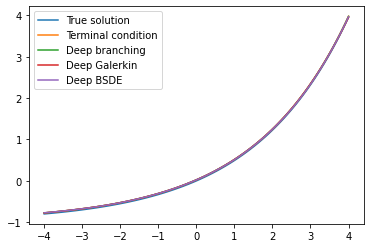

In [23]:
# Performance comparison full
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    #disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn", #3000
                    branch_nb_states=1000, branch_nb_path_per_state=100000, #1000,100000
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,#200
                    bsde_nb_states=1000, bsde_nb_time_intervals=4, #1000,4
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example, #10000
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 2 seconds; L1 error: 2.20E-02; L2 error: 5.75E-04; rel error: 6.33E-02.
fdb runtime: 0 seconds; total runtime: 2 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 4 seconds; L1 error: 4.90E-02; L2 error: 2.97E-03; rel error: 1.28E-01.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 9 seconds; L1 error: 1.32E-01; L2 error: 1.83E-02; rel error: 4.28E-01.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 3 seconds; L1 error: 2.35E-02; L2 error: 7.38E-04; rel error: 1.15E-01.
fdb runtime: 0 seconds; total runtime: 3 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 5 seconds; L1 error: 3.25E-02; L2 error: 1.46E-03; rel error: 7.15E-02.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 9 seconds; L1 error: 1.04E-01; L2 error: 1.10E-02; rel error: 4.01E-01

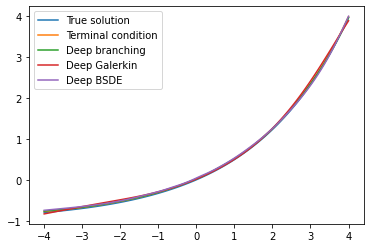

In [14]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    #disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=300, fname="allen_cahn", #3000
                    branch_nb_states=100, branch_nb_path_per_state=10000, #1000,100000
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=20,#200
                    bsde_nb_states=100, bsde_nb_time_intervals=4, #1000,4
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example, #10000
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)



### Smoothened Payoff
$\phi(y)=\frac{\sqrt{(e^{\sigma y} - K)^2}+ (e^{\sigma y}-K)}{2}$

In [24]:
# function definition
import constant as cst
deriv_map = np.array([0,1]).reshape(-1, 1)
def f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    v = -cst.r*y[0]+(cst.r-cst.sigma*cst.sigma/2)/cst.sigma*y[1]
    return v

dgm_deriv_map = np.array([0,1,2]).reshape(-1, 1)
def dgm_f_example(y):
    """
    idx 0 -> no deriv
    idx 1 -> first deriv
    idx 2 -> second deriv
    """
    v = .5*y[2]-cst.r*y[0]+(cst.r-cst.sigma*cst.sigma/2)/cst.sigma*y[1]
    return v

def phi_example(x):
    v = (torch.sqrt((torch.exp(cst.sigma*x[0])-cst.K)*(torch.exp(cst.sigma*x[0])-cst.K))+(torch.exp(cst.sigma*x[0])-cst.K))/2
    return v 

def exact_example(t, x, T):
    d1 = (cst.sigma*x[0]-np.log(cst.K) + (cst.r + 0.5 * cst.sigma*cst.sigma) * (T - t)) / cst.sigma /np.sqrt(T-t)
    d2 = d1 - cst.sigma*np.sqrt(T-t)
    v = np.exp(cst.sigma*x[0])*scipy.stats.norm.cdf(d1) - np.exp(-cst.r * (T - t)) * scipy.stats.norm.cdf(d2)
    return v

t_lo, x_lo, x_hi, n = 0., -4., 4., 0
grid = np.linspace(x_lo, x_hi, 100) 
grid_d_dim = np.expand_dims(grid, axis=0)
grid_d_dim_with_t = np.concatenate((t_lo * np.ones((1, 100)), grid_d_dim), axis=0)

T = .5
true = exact_example(t_lo, grid_d_dim, T)
terminal = exact_example(T, grid_d_dim, T)

<ipython-input-24-c0664ae8475e>:28: RuntimeWarning: divide by zero encountered in true_divide
  d1 = (cst.sigma*x[0]-np.log(cst.K) + (cst.r + 0.5 * cst.sigma*cst.sigma) * (T - t)) / cst.sigma /np.sqrt(T-t)


#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 147 seconds; L1 error: 1.07E-03; L2 error: 1.81E-06; rel error: 1.20E+05.
fdb runtime: 0 seconds; total runtime: 147 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 51 seconds; L1 error: 2.95E-03; L2 error: 4.45E-05; rel error: 4.48E+04.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 82 seconds; L1 error: 3.82E-03; L2 error: 2.29E-05; rel error: 1.81E+05.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 145 seconds; L1 error: 2.36E-03; L2 error: 9.82E-06; rel error: 9.09E+04.
fdb runtime: 0 seconds; total runtime: 145 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 51 seconds; L1 error: 2.23E-03; L2 error: 2.24E-05; rel error: 5.05E+04.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 83 seconds; L1 error: 7.98E-03; L2 error: 7.80E-05; rel err

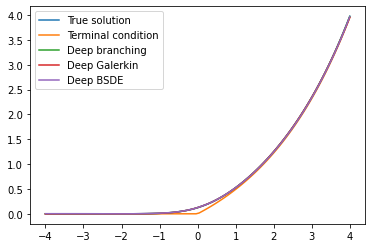

In [25]:
# Performance comparison full
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    #disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=3000, fname="allen_cahn", #3000
                    branch_nb_states=1000, branch_nb_path_per_state=100000, #1000,100000
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=200,#200
                    bsde_nb_states=1000, bsde_nb_time_intervals=4, #1000,4
                    dgm_nb_states=10000, f_fun=f_example, dgm_f_fun=dgm_f_example, #10000
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)

#### Starting deep branching method with seed 0 - 1 out of 10 times
Time taken: 2 seconds; L1 error: 7.32E-03; L2 error: 1.11E-04; rel error: 4.37E+05.
fdb runtime: 0 seconds; total runtime: 2 seconds.
#### Starting deep galerkin method with seed 0 - 1 out of 10 times
Time taken: 5 seconds; L1 error: 3.40E-02; L2 error: 1.67E-03; rel error: 3.06E+06.
#### Starting deep BSDE method with seed 0 - 1 out of 10 times
Time taken: 8 seconds; L1 error: 9.50E-02; L2 error: 1.02E-02; rel error: 6.11E+06.


#### Starting deep branching method with seed 1 - 2 out of 10 times
Time taken: 2 seconds; L1 error: 5.87E-03; L2 error: 7.40E-05; rel error: 2.17E+05.
fdb runtime: 0 seconds; total runtime: 2 seconds.
#### Starting deep galerkin method with seed 1 - 2 out of 10 times
Time taken: 6 seconds; L1 error: 2.70E-02; L2 error: 1.22E-03; rel error: 4.19E+06.
#### Starting deep BSDE method with seed 1 - 2 out of 10 times
Time taken: 8 seconds; L1 error: 7.71E-02; L2 error: 6.28E-03; rel error: 4.66E+06

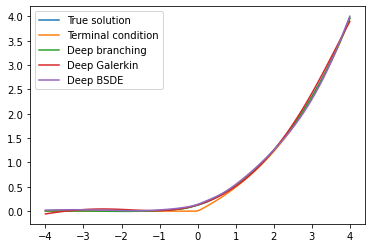

In [17]:
# Performance comparison
compare_performance(grid, grid_d_dim, grid_d_dim_with_t, t_lo, true, terminal=terminal, # seeds=[0],
                    #disable_bsde=True, disable_galerkin=True, verbose=True, debug_mode=True,
                    T=T, device=device, epochs=300, fname="allen_cahn", #3000
                    branch_nb_states=100, branch_nb_path_per_state=10000, #1000,100000
                    branch_patches=1, branch_exponential_lambda=-math.log(.95)/T,
                    branch_nb_states_per_batch=20,#200
                    bsde_nb_states=100, bsde_nb_time_intervals=4, #1000,4
                    dgm_nb_states=1000, f_fun=f_example, dgm_f_fun=dgm_f_example, #10000
                    deriv_map=deriv_map, dgm_deriv_map=dgm_deriv_map, phi_fun=phi_example)